In [1]:
using LinearAlgebra;
using SparseArrays;
using Plots;
using ArrayFire;

ArrayFire v3.6.2 (CUDA, 64-bit Windows, build dc38ef13)
Platform: CUDA Toolkit 10, Driver: CUDA Driver Version: 10000
[0] GeForce GTX 960M, 4096 MB, CUDA Compute 5.0


In [2]:
#Structs
struct Material
    E::Float64                  #Young's Modulus
    v::Float64                  #Poisson's Ratio
    Area::Float64
    THIC::Float64               #Thickness
end

struct Element
    Type::Int64                 #Plane Stress/Strain
    Node::Array{Float64,2}      #Nodes in Element
    Material::Int64             #Material Number
    NINT::Int64                 #Gauss Numerical Integration Order
    LM::Array{Int64,1}          #DOF Indices
    NN::Array{Int64,1}          #Node Numbers
end

struct ElementGroup
    NUME::Int64                 #Number of Elements
    Type::Int64                 #Quads/OFE
    Ele::Array{Element,1}       #Array of Elements
end

In [3]:
#Setting up FEM
function OFESolve(IIN; verbose = false, tradmode = false, useGPU = false)
    global Verbose = verbose;
    global line = 1;
    f = open(IIN);
    global text = readlines(f);
    close(f);
    global p = plot(0,0);
    global usingOFE = false;
    global TradMode = tradmode;
    global UseGPU = useGPU;
    global NumMonomials = 6; #3 = Linear, 4 = Bilinear, 6 = Quadratic
    
    if (~verbose) print("Control Information\t\t\t"); end
    @time RCI();
    if (~verbose) print("Nodal Inputs\t\t\t\t"); end
    @time ReadInput();
    if (~verbose) print("Resolve Number of Independent Equations\t"); end
    @time IDDOF();
    if (~verbose) print("Read Load Information\t\t\t"); end
    @time Loads();
    if (~verbose) print("Read Element Information\t\t"); end
    @time ReadElement();
    if (~verbose) print("Assemble Global Stiffness Matrix\t"); end
    @time K = Assem();
    if (~verbose) print("Assemble Load Vector\t\t\t"); end
    @time UpdateLoad();
    if (~verbose) print("Solve DOF\t\t\t\t"); end
    @time Solve(K);
    if (~verbose) print("Update Displacements if OFE is used\t") end
    @time UpdateNodes();
    print("Total Time\t\t\t\t");
end

OFESolve (generic function with 1 method)

In [4]:
#Read Line by Line
function RL()
    global line += 1;
    return parse(Float64,text[line-1]);
end

RL (generic function with 1 method)

In [5]:
#Gauss-Quadrature Functions
function Legendre(n,x)
    #Algorithm taken from https://en.wikipedia.org/wiki/Gaussian_quadrature#Gauss%E2%80%93Legendre_quadrature
    if (n == 0)
        return 1;
    elseif (n == 1)
        return x;
    else
        return ((2*n-1)*x/n)*Legendre(n-1,x) - ((n-1)/n)*Legendre(n-2,x);
    end
end

function GaussPoints(n)
    points = zeros(1,n);
    #Algorithm taken from https://math.stackexchange.com/questions/12160/roots-of-legendre-polynomial
    if (n == 1)
        points = [0.0];
    elseif (n == 2)
        points = [-0.5773502691896 0.5773502691896];
    elseif (n == 3)
        points = [-0.7745966692415 0.0 0.7745966692415];
    elseif (n == 4)
        points = [0.8611363115941 -0.3399810435849 0.3399810435849 0.8611363115941];
    else
        for i = 1:n
            points[n+1-i] = (1 - (1/(8*(n^2))) + (1/(8*(n^3))))*cos(pi*(4*i-1)/(4*n + 2));
        end
    end
    return points;
end


function GaussWeights(n)
    weights = zeros(1,n);
    x = GaussPoints(n);
    #Algorithm taken from http://mathworld.wolfram.com/Legendre-GaussQuadrature.html
    if (n == 1)
        weights = [2.0];
    elseif (n == 2)
        weights = [1.0 1.0];
    elseif (n == 3)
        weights = [5/9 8/9 5/9];
    elseif (n == 4)
        weights = [0.3478548451375 0.6521451548625 0.6521451548625 0.3478548451375];
    else
        for i = 1:n
            weights[i] = 2*(1 - (x[i]^2))/(((n+1)^2)*(Legendre(n+1,x[i])^2));
        end
    end
    return weights;
end

function λ1(x,y)
    ans = (-x - (y-1));
    return ans;
end

function λ2(x,y)
    ans = x;
    return ans;
end

function λ3(x,y)
    return 1 - λ1(x,y) - λ2(x,y);
end

function Barycentric(x,y)
    return [λ1(x,y), λ2(x,y), λ3(x,y)];
end

function TriangleGaussPoints()
#Data taken from https://people.sc.fsu.edu/~jburkardt/datasets/quadrature_rules_tri/quadrature_rules_tri.html
    GP = [0.33333333333333331       0.33333333333333331     
      2.06349616025259287E-002  0.48968251919873701     
      0.48968251919873701       2.06349616025259287E-002
      0.48968251919873701       0.48968251919873701     
      0.12582081701412900       0.43708959149293553     
      0.43708959149293553       0.12582081701412900     
      0.43708959149293553       0.43708959149293553     
      0.62359292876193562       0.18820353561903219     
      0.18820353561903219       0.62359292876193562     
      0.18820353561903219       0.18820353561903219     
      0.91054097321109406       4.47295133944529688E-002
      4.47295133944529688E-002  0.91054097321109406     
      4.47295133944529688E-002  4.47295133944529688E-002
      0.74119859878449801       3.68384120547362581E-002
      0.74119859878449801       0.22196298916076573     
      3.68384120547362581E-002  0.74119859878449801     
      3.68384120547362581E-002  0.22196298916076573     
      0.22196298916076573       0.74119859878449801     
      0.22196298916076573       3.68384120547362581E-002];
    ans = zeros(length(GP[:,1]),3);
    for i = 1:length(GP[:,1])
       ans[i,:] = Barycentric(GP[i,1],GP[i,2]);
    end
    return ans;
end

function TriangleGaussWeights()
    return [9.71357962827961025E-002
  3.13347002271398278E-002
  3.13347002271398278E-002
  3.13347002271398278E-002
  7.78275410047754301E-002
  7.78275410047754301E-002
  7.78275410047754301E-002
  7.96477389272090969E-002
  7.96477389272090969E-002
  7.96477389272090969E-002
  2.55776756586981006E-002
  2.55776756586981006E-002
  2.55776756586981006E-002
  4.32835393772893970E-002
  4.32835393772893970E-002
  4.32835393772893970E-002
  4.32835393772893970E-002
  4.32835393772893970E-002
  4.32835393772893970E-002];
end

TriangleGaussWeights (generic function with 1 method)

In [6]:
#Manager for Element types
function Elemnt(Type, IND, K)
    if (Type == 1)
        Quads(IND, K);
    elseif (Type == 2)
        TriOFE2D(IND, K);
    else
        #Error
    end
end

Elemnt (generic function with 1 method)

In [7]:
function plotmesh()
    #global Mesh = Array{Float64,1}(undef,0);
    global plt = plot(0,0, legend = :none, line = :blue);
    for i = 1:NUMEG
        Elemnt(EG[i].Type, 4, ~);
    end
    plt
end

plotmesh (generic function with 1 method)

In [8]:
#Jacobian Solver for 2D Quadrilateral Elements
function STDM(R, S, Ele)
    RP = 1+R;
    SP = 1+S;
    RM = 1-R;
    SM = 1-S;
    
    P = 0.25*[SP -SP -SM SM;
              RP RM -RM -RP];
    QNodes = Ele.Node[:,1:2];
    XJ = P*QNodes;
    M = inv(XJ)*P;
    B = zeros(3,8);
    for i = 1:8
        j = Int(1.5 + 0.5*((-1)^i));
        k = Int(ceil(i/2));
        B[j,i] = M[j,k];
        B[3,i] = M[(j%2)+1,k];
    end
    return [B,det(XJ)];
end

STDM (generic function with 1 method)

In [9]:
#FEM Solver for 2D Quadrilateral Elements 
function Quads(IND, K)
    if (IND == 1)        
                                                    if (Verbose) println("Quads"); end
        NUMMAT = Int(RL());
        if (NUMMAT == 0) NUMMAT = 1; end
        NUME = Int(RL());
        E = zeros(1,NUMMAT);
        THIC = zeros(1,NUMMAT);
        v = zeros(1,NUMMAT);
        resize!(Mat, length(Mat) + NUMMAT);
        for i = 1:NUMMAT
            N = Int(RL());                          if (Verbose) println("\tMaterial ", N, "/", NUMMAT); end
            E[N] = RL();                            if (Verbose) println("\t\tYoung's Modulus:\t", E[N]); end
            THIC[N] = RL();                         if (Verbose) println("\t\tThickness:\t\t", THIC[N]); end
            v[N] = RL();                            if (Verbose) println("\t\tPoisson's Ratio:\t", v[N]); end
            Mat[length(Mat)-NUMMAT+i] = Material(E[N],v[N],0,THIC[N]);
        end
        
        Ele = Array{Element,1}(undef, 0);
        resize!(Ele, length(Ele) + NUME);
        NN = vec(zeros(1,4));
        
        for N = 1:NUME
            LM = Array{Int64,1}(undef, 0);
                qNodes = zeros(4,3);
            resize!(LM, 12);
            M = Int(RL());                          if (Verbose) println("\tElement ", M, "/", NUME); end
                                                    if (Verbose) print("\t\tNodes:\t"); end
            for i = 1:4
                qN = Int(RL());                     if (Verbose) print(qN, " "); end
                for j = 1:3
                    qNodes[i,j] = Node[qN,j];
                    LM[(i-1)*3 + j] = ID[qN,j];
                end
                NN[i] = qN;
                FENodes[qN] = 1;
            end           
                                                    if (Verbose) println("\n\t\tLM:\t", LM); end
            MTYP = Int(RL());                       if (Verbose) println("\t\tMaterial Type:\t", MTYP); end
            STYP = Int(RL());                       if (Verbose) println("\t\tStress Type:\t", STYP); end
            NINT = Int(RL());                       if (Verbose) println("\t\tGauss Order:\t", NINT); end
            Ele[N] = Element(STYP,qNodes,MTYP,NINT,LM,NN);
        end
        
        resize!(EG, length(EG) + 1);
        EG[length(EG)] = ElementGroup(NUME,1,Ele);
        
    elseif (IND == 2)
        findEG = 1;
        while (EG[findEG].Type != 1) findEG += 1; end
        EleGroup = EG[findEG];
        if (usingOFE)
           global MeshStep = dist(EleGroup.Ele[1].Node[1,1:2], EleGroup.Ele[1].Node[2,1:2]); 
        end
        for N = 1:EleGroup.NUME
            Ele = EleGroup.Ele[N];
            MTYPE = Ele.Material;
            F = Mat[MTYPE].E/(1+Mat[MTYPE].v);
            G = F*Mat[MTYPE].v/(1-2*Mat[MTYPE].v);
            H = F+G;
            D = [H G 0;
                 G H 0;
                 0 0 F/2];
            if (Ele.Type == 1)
                XBAR = 1;
            elseif (Ele.Type == 2)
                D -= [(G^2)/H (G^2)/H 0;
                      (G^2)/H (G^2)/H 0;
                      0 0 0];
                XBAR = Mat[MTYPE].THIC;
            end

#If not running OFE, use this
            if (!usingOFE)
                S = zeros(8,8);
                Pts = GaussPoints(Ele.NINT);
                Wts = GaussWeights(Ele.NINT);
                for LX = 1:Ele.NINT
                    RI = Pts[LX];
                    for LY = 1:Ele.NINT
                        SI = Pts[LY];
                        Res = STDM(RI,SI,Ele);
                        B = Res[1];
                        DET = Res[2];
                        WT = Wts[LX]*Wts[LY]*XBAR*DET;
                        S += B'*D*B*WT;
                    end
                end
                LM = zeros(1,8);
                for i = 1:4
                    for j = 1:2
                        LM[(i-1)*2+j] = Ele.LM[(i-1)*3+j];
                    end
                end
                for i = 1:8
                    I = Int(LM[i]);
                    for j = 1:8
                        J = Int(LM[j]);
                        if (I != 0)&&(J != 0)
                            K[I,J] += S[i,j];
                        end
                    end
                end
            
#Else run this code instead
            else
                S = zeros(8,8);
                Pts = GaussPoints(Ele.NINT);
                Wts = GaussWeights(Ele.NINT);
                for LX = 1:Ele.NINT
                    RI = Pts[LX];
                    for LY = 1:Ele.NINT
                        SI = Pts[LY];
                        Res = STDM(RI,SI,Ele);
                        B = Res[1];
                        DET = Res[2];
                        WT = Wts[LX]*Wts[LY]*XBAR*DET;
                        S += B'*D*B*WT;
                    end
                end
                LM = zeros(1,8);
                for i = 1:4
                    for j = 1:2
                        LM[(i-1)*2+j] = OFEID[Ele.NN[i],(j-1)*NumMonomials+1];
                    end
                end
                for i = 1:8
                    I = Int(LM[i]);
                    for j = 1:8
                        J = Int(LM[j]);
                        if (I != 0)&&(J != 0)
                            K[I,J] += S[i,j];
                            #Threads.atomic_add!(K[I,J], S[i,j]);
                        end
                    end
                end
            end
            
        end
    elseif (IND == 3)
        #Code for Stress Recovery
    elseif (IND == 4)
        findEG = 1;
        while (EG[findEG].Type != 1) findEG += 1; end
        EleGroup = EG[findEG];
        for N = 1:EleGroup.NUME
            Ele = EleGroup.Ele[N];
            xplt = [Ele.Node[:,1]; Ele.Node[1,1]];
            yplt = [Ele.Node[:,2]; Ele.Node[1,2]];
            plot!(plt, xplt, yplt, legend = :none, line = :blue);
        end
    elseif (IND == 5)
        findEG = 1;
        while (EG[findEG].Type != 1) findEG += 1; end
        EleGroup = EG[findEG];
        for N = 1:EleGroup.NUME
            Ele = EleGroup.Ele[N];
            xplt = zeros(5,1);
            yplt = zeros(5,1);
            for i = 1:5
                xplt[i] = displacedNodes[Ele.NN[(i-1)%4+1],1];
                yplt[i] = displacedNodes[Ele.NN[(i-1)%4+1],2];
            end
            plot!(solnplt, xplt, yplt, legend = :none, line = :blue);
        end
    else
        #Error
    end
end

Quads (generic function with 1 method)

In [10]:
#2D TriOFE Functions
function W(s::Float64)
    if (s >= 1)
        return 0;
    else
        return 1 - 6*s^2 + 8*s^3 - 3*s^4;
    end
end

function dist(I,J)
    return sqrt(sum((I-J).^2));
end

function Φ(I,J,i,Nd1,Nd2,Nd3,Rad)
    S = zeros(3,6);
    ans = 0;
    alpha = 1;
    EP = zeros(3,2);
    EP[1,1] = (Nd1[1]+Nd2[1])/2;
    EP[1,2] = (Nd1[2]+Nd2[2])/2;
    EP[2,1] = (Nd2[1]+Nd3[1])/2;
    EP[2,2] = (Nd2[2]+Nd3[2])/2;
    EP[3,1] = (Nd3[1]+Nd1[1])/2;
    EP[3,2] = (Nd3[2]+Nd1[2])/2;
    
    
    if (i == J)
        ans = 1;
    elseif ((i <= 3)&&(J <= 3))
        ans = 0;
    else            
        S[1,4] = dist(EP[1,1:2],Nd1[1:2])/(alpha*Rad[1]);
        S[1,5] = dist(EP[2,1:2],Nd1[1:2])/(alpha*Rad[1]);
        S[1,6] = dist(EP[3,1:2],Nd1[1:2])/(alpha*Rad[1]);
        S[2,4] = dist(EP[1,1:2],Nd2[1:2])/(alpha*Rad[2]);
        S[2,5] = dist(EP[2,1:2],Nd2[1:2])/(alpha*Rad[2]);
        S[2,6] = dist(EP[3,1:2],Nd2[1:2])/(alpha*Rad[2]);
        S[3,4] = dist(EP[1,1:2],Nd3[1:2])/(alpha*Rad[3]);
        S[3,5] = dist(EP[2,1:2],Nd3[1:2])/(alpha*Rad[3]);
        S[3,6] = dist(EP[3,1:2],Nd3[1:2])/(alpha*Rad[3]);

        if (I == 1)
            if (i == 4)
                ans = W(S[J,i])/(W(S[1,i]) + W(S[2,i]));
                if (J == 3)
                    ans = 0;
                end
            elseif (i == 5)
                ans = W(S[J,i])/(W(S[1,i]) + W(S[2,i]) + W(S[3,i]));
            elseif (i == 6)
                ans = W(S[J,i])/(W(S[1,i]) + W(S[3,i]));
                if (J == 2)
                    ans = 0;
                end
            end
        elseif (I == 2)
            if (i == 4)
                ans = W(S[J,i])/(W(S[1,i]) + W(S[2,i]));
                if (J == 3)
                    ans = 0;
                end
            elseif (i == 5)
                ans = W(S[J,i])/(W(S[2,i]) + W(S[3,i]));
                if (J == 1)
                    ans = 0;
                end
            elseif (i == 6)
                ans = W(S[J,i])/(W(S[1,i]) + W(S[2,i]) + W(S[3,i]));
            end
        elseif (I == 3)
            if (i == 4)
                ans = W(S[J,i])/(W(S[1,i]) + W(S[2,i]) + W(S[3,i]));
            elseif (i == 5)
                ans = W(S[J,i])/(W(S[2,i]) + W(S[3,i]));
                if (J == 1)
                    ans = 0;
                end
            elseif (i == 6)
                ans = W(S[J,i])/(W(S[1,i]) + W(S[3,i]));
                if (J == 2)
                    ans = 0;
                end
            end
        end
    end
    return ans;
end

function A(Nodes) #Area
    Nds = [Nodes; Nodes[1,:]'];
    ans = 0;
    for i = 1:3
        ans += 0.5*(Nds[i,1]*Nds[i+1,2] - Nds[i+1,1]*Nds[i,2]);
    end
    return ans;
end

function h(i, I, J, K, Nd, NINT)
    ans = 0;
    j = i%3 + 1;
    k = (i+1)%3 + 1;
    Nodes = [I'; J'; K'];
    Area = A(Nodes);
    #r = (j+1)%3 + 1;
    #s = (j+2)%3 + 1;
    s = j;
    r = k;
    ai = (Nodes[s,1]*Nodes[r,2] - Nodes[r,1]*Nodes[s,2])/(2*Area);
    bi = (Nodes[s,2] - Nodes[r,2])/(2*Area);
    ci = (Nodes[r,1] - Nodes[s,1])/(2*Area);
    Li = ai + bi*Nd[1] + ci*Nd[2];
    Lj = 0;
    if (NINT == 1) ans = Li;
    elseif (NINT == 2) ans = bi;       #This is for dh/dx (1st order shape function h)
    elseif (NINT == 3) ans = ci;       #This is for dh/dy (1st order shape function h)
    elseif (NINT == 4)
        if (i <= 3) ans = Li*(2*Li - 1);
        else
            s = j%3 + 1;
            r = k%3 + 1;
            aj = (Nodes[s,1]*Nodes[r,2] - Nodes[r,1]*Nodes[s,2])/(2*Area);
            bj = (Nodes[s,2] - Nodes[r,2])/(2*Area);
            cj = (Nodes[r,1] - Nodes[s,1])/(2*Area);
            Lj = aj + bj*Nd[1] + cj*Nd[2];
            ans = 4*Li*Lj;
        end        
    elseif (NINT == 5)        #This is for dh/dx (2nd order shape function h)
        if (i <= 3) ans = 4*bi*Li - bi;
        else
            s = j%3 + 1;
            r = k%3 + 1;
            aj = (Nodes[s,1]*Nodes[r,2] - Nodes[r,1]*Nodes[s,2])/(2*Area);
            bj = (Nodes[s,2] - Nodes[r,2])/(2*Area);
            cj = (Nodes[r,1] - Nodes[s,1])/(2*Area);
            Lj = aj + bj*Nd[1] + cj*Nd[2];
            ans = 4*(bi*Lj + bj*Li);
        end
    elseif (NINT == 6)        #This is for dh/dy (2nd order shape function h)
        if (i <= 3) ans = 4*ci*Li - ci;
        else
            s = j%3 + 1;
            r = k%3 + 1;
            aj = (Nodes[s,1]*Nodes[r,2] - Nodes[r,1]*Nodes[s,2])/(2*Area);
            bj = (Nodes[s,2] - Nodes[r,2])/(2*Area);
            cj = (Nodes[r,1] - Nodes[s,1])/(2*Area);
            Lj = aj + bj*Nd[1] + cj*Nd[2];
            ans = 4*(ci*Lj + cj*Li);
        end
    end
    return ans;
end

function OFERadius(Nd, Connections)
    Radius = 0;
    for i = 1:length(Connections)
        if (Connections[i] != 0)
            if (Radius == 0) 
                Radius = dist(Node[Nd,:], Node[i,:]);
            else
                if (dist(Node[Nd,:], Node[i,:]) > Radius)
                    Radius = dist(Node[Nd,:], Node[i,:]);
                end
            end
        end
    end
    if (FENodes[Nd] > 1)
        Radius = max(Radius,sqrt(2)*MeshStep);
    end
    return Radius;
end

function OFE2DSTDM(Nodes, GP, Nd)
    B = zeros(3,6*NumMonomials);
    Rad = vec(zeros(1,3));
    for i = 1:3
        Rad[i] = OFERadius(Nd[i], OFEM[Nd[i],:]);
    end
    Pm = zeros(3,6);
    Pm[:,1] = ones(3,1);
    Pm[:,2] = (GP[1]*ones(3,1) - Nodes[:,1]);
    Pm[:,3] = (GP[2]*ones(3,1) - Nodes[:,2]);
    Pm[:,4] = ((GP[1]*ones(3,1) - Nodes[:,1]).*(GP[2]*ones(3,1) - Nodes[:,2]));  
    Pm[:,5] = (GP[1]*ones(3,1) - Nodes[:,1]).*(GP[1]*ones(3,1) - Nodes[:,1]);
    Pm[:,6] = (GP[2]*ones(3,1) - Nodes[:,2]).*(GP[2]*ones(3,1) - Nodes[:,2]);
    
    dPmdx = zeros(3,6);
    dPmdy = zeros(3,6);
    for i = 1:3
        dPmdx[i,:] = [0, 1, 0, GP[2]-Nodes[i,2], 2*(GP[1]-Nodes[i,1]), 0];
        dPmdy[i,:] = [0, 0, 1, GP[1]-Nodes[i,1], 0, 2*(GP[2]-Nodes[i,2])];
    end
    
    ρsum = 0;
    
    for I = 1:3
        tm1 = 0;
        tm2x = 0;
        tm3x = 0;
        tm2y = 0;
        tm3y = 0;
        
        for k = 1:3
            ϕIK = 0;
            dϕIKdx = 0;
            dϕIKdy = 0;
            for i = 1:6
                hi = h(i,Nodes[1,1:2],Nodes[2,1:2],Nodes[3,1:2],GP,4);
                dhidx = h(i,Nodes[1,1:2],Nodes[2,1:2],Nodes[3,1:2],GP,5);
                dhidy = h(i,Nodes[1,1:2],Nodes[2,1:2],Nodes[3,1:2],GP,6);
                ΦIK = Φ(k,I,i,Nodes[1,1:2],Nodes[2,1:2],Nodes[3,1:2],Rad);
                
                ϕIK += hi*ΦIK;
                dϕIKdx += dhidx*ΦIK;
                dϕIKdy += dhidy*ΦIK;
            end
            hK = h(k,Nodes[1,1:2],Nodes[2,1:2],Nodes[3,1:2],GP,1);
            dhKdx = h(k,Nodes[1,1:2],Nodes[2,1:2],Nodes[3,1:2],GP,2);
            dhKdy = h(k,Nodes[1,1:2],Nodes[2,1:2],Nodes[3,1:2],GP,3);
            tm1 += hK*ϕIK;
            tm2x += dhKdx*ϕIK;
            tm3x += hK*dϕIKdx;
            tm2y += dhKdy*ϕIK;
            tm3y += hK*dϕIKdy;
        end
        dρImdx = zeros(4,1);
        dρImdy = zeros(4,1);
        
        
        ρI = tm1;
        dρIdx = tm2x + tm3x;
        dρIdy = tm2y + tm3y;
        
        ρsum += ρI;
        
        #At high alpha's, these should be equal
        #=
        println(ρI, "\t", h(I,Nodes[1,1:2],Nodes[2,1:2],Nodes[3,1:2],GP,1));
        println(dρIdx, "\t", h(I,Nodes[1,1:2],Nodes[2,1:2],Nodes[3,1:2],GP,2));
        println(dρIdy, "\t", h(I,Nodes[1,1:2],Nodes[2,1:2],Nodes[3,1:2],GP,3));
        =#
        #=
        println(abs(ρI - h(I,Nodes[1,1:2],Nodes[2,1:2],Nodes[3,1:2],GP,1)) > 1e-8);
        println(abs(dρIdx - h(I,Nodes[1,1:2],Nodes[2,1:2],Nodes[3,1:2],GP,2)) > 1e-8);
        println(abs(dρIdy - h(I,Nodes[1,1:2],Nodes[2,1:2],Nodes[3,1:2],GP,3)) > 1e-8);
        =#
        
        
        dρImdx = dPmdx[I,:]*ρI + Pm[I,:]*dρIdx;
        dρImdy = dPmdy[I,:]*ρI + Pm[I,:]*dρIdy;
        
        for m = 1:NumMonomials
            B[1,(I-1)*2*NumMonomials+2*m-1] = dρImdx[m];
            B[2,(I-1)*2*NumMonomials+2*m] = dρImdy[m];
            B[3,(I-1)*2*NumMonomials+2*m-1] = dρImdy[m];
            B[3,(I-1)*2*NumMonomials+2*m] = dρImdx[m];
        end        
    end
    return B;
end

function Coupling2DSTDM(Nodes, GP, Nd, Case)
    B = zeros(3,6*NumMonomials);
    Rad = vec(zeros(1,3));
    for i = 1:3
        Rad[i] = OFERadius(Nd[i], OFEM[Nd[i],:]);
    end
    #println(Rad, Nd)
    Pm = zeros(3,6);
    Pm[:,1] = ones(3,1);
    Pm[:,2] = (GP[1]*ones(3,1) - Nodes[:,1]);
    Pm[:,3] = (GP[2]*ones(3,1) - Nodes[:,2]);
    Pm[:,4] = ((GP[1]*ones(3,1) - Nodes[:,1]).*(GP[2]*ones(3,1) - Nodes[:,2]));  
    Pm[:,5] = (GP[1]*ones(3,1) - Nodes[:,1]).*(GP[1]*ones(3,1) - Nodes[:,1]);
    Pm[:,6] = (GP[2]*ones(3,1) - Nodes[:,2]).*(GP[2]*ones(3,1) - Nodes[:,2]);
    
    dPmdx = zeros(3,6);
    dPmdy = zeros(3,6);
    for i = 1:3
        dPmdx[i,:] = [0, 1, 0, GP[2]-Nodes[i,2], 2*(GP[1]-Nodes[i,1]), 0];
        dPmdy[i,:] = [0, 0, 1, GP[1]-Nodes[i,1], 0, 2*(GP[2]-Nodes[i,2])];
    end
    
    if (Case == 1)      #I is Traditional, L and M are MFS
        ϕIL = 0;
        dϕILdx = 0;
        dϕILdy = 0;
        
        ϕIM = 0;        
        dϕIMdx = 0;
        dϕIMdy = 0;
        
        ϕLL = 0;
        dϕLLdx = 0;
        dϕLLdy = 0;
        
        ϕLM = 0;
        dϕLMdx = 0;
        dϕLMdy = 0;
        
        ϕML = 0;
        dϕMLdx = 0;
        dϕMLdy = 0;
        
        ϕMM = 0;
        dϕMMdx = 0;
        dϕMMdy = 0;
        for i = 1:6
            hi = h(i,Nodes[1,1:2],Nodes[2,1:2],Nodes[3,1:2],GP,4);
            dhidx = h(i,Nodes[1,1:2],Nodes[2,1:2],Nodes[3,1:2],GP,5);
            dhidy = h(i,Nodes[1,1:2],Nodes[2,1:2],Nodes[3,1:2],GP,6);
            
            ΦIL = Φ(2,1,i,Nodes[1,1:2],Nodes[2,1:2],Nodes[3,1:2],Rad);
            ϕIL += hi*ΦIL;
            dϕILdx += dhidx*ΦIL;
            dϕILdy += dhidy*ΦIL;
            
            ΦLL = Φ(2,2,i,Nodes[1,1:2],Nodes[2,1:2],Nodes[3,1:2],Rad);
            ϕLL += hi*ΦLL;
            dϕLLdx += dhidx*ΦLL;
            dϕLLdy += dhidy*ΦLL;
            
            ΦML = Φ(2,3,i,Nodes[1,1:2],Nodes[2,1:2],Nodes[3,1:2],Rad);
            ϕML += hi*ΦML;
            dϕMLdx += dhidx*ΦML;
            dϕMLdy += dhidy*ΦML;
            
            ΦIM = Φ(3,1,i,Nodes[1,1:2],Nodes[2,1:2],Nodes[3,1:2],Rad);            
            ϕIM += hi*ΦIM;
            dϕIMdx += dhidx*ΦIM;
            dϕIMdy += dhidy*ΦIM;
            
            ΦLM = Φ(3,2,i,Nodes[1,1:2],Nodes[2,1:2],Nodes[3,1:2],Rad);
            ϕLM += hi*ΦLM;
            dϕLMdx += dhidx*ΦLM;
            dϕLMdy += dhidy*ΦLM;
            
            ΦMM = Φ(3,3,i,Nodes[1,1:2],Nodes[2,1:2],Nodes[3,1:2],Rad);
            ϕMM += hi*ΦMM;
            dϕMMdx += dhidx*ΦMM;
            dϕMMdy += dhidy*ΦMM;
        end
        hI = h(1,Nodes[1,1:2],Nodes[2,1:2],Nodes[3,1:2],GP,1);
        dhIdx = h(1,Nodes[1,1:2],Nodes[2,1:2],Nodes[3,1:2],GP,2);
        dhIdy = h(1,Nodes[1,1:2],Nodes[2,1:2],Nodes[3,1:2],GP,3);
        
        hL = h(2,Nodes[1,1:2],Nodes[2,1:2],Nodes[3,1:2],GP,1);
        dhLdx = h(2,Nodes[1,1:2],Nodes[2,1:2],Nodes[3,1:2],GP,2);
        dhLdy = h(2,Nodes[1,1:2],Nodes[2,1:2],Nodes[3,1:2],GP,3);
        
        hM = h(3,Nodes[1,1:2],Nodes[2,1:2],Nodes[3,1:2],GP,1);
        dhMdx = h(3,Nodes[1,1:2],Nodes[2,1:2],Nodes[3,1:2],GP,2);
        dhMdy = h(3,Nodes[1,1:2],Nodes[2,1:2],Nodes[3,1:2],GP,3);
        
        CM = hI + hL*ϕIL + hM*ϕIM;
        dCMdx = dhIdx + dhLdx*ϕIL + hL*dϕILdx + dhMdx*ϕIM + hM*dϕIMdx;
        dCMdy = dhIdy + dhLdy*ϕIL + hL*dϕILdy + dhMdy*ϕIM + hM*dϕIMdy;
        
        dρIdx = dhIdx*CM + hI*dCMdx;
        dρIdy = dhIdy*CM + hI*dCMdy;
        
        dρLdx = Pm[2,:]*(dhLdx*ϕLL + hL*dϕLLdx + dhMdx*ϕLM + hM*dϕLMdx) + dPmdx[2,:]*(hL*ϕLL + hM*ϕLM);
        dρLdy = Pm[2,:]*(dhLdy*ϕLL + hL*dϕLLdy + dhMdy*ϕLM + hM*dϕLMdy) + dPmdy[2,:]*(hL*ϕLL + hM*ϕLM);
        dρLdx[1] += dhLdx*CM + hL*dCMdx;
        dρLdy[1] += dhLdy*CM + hL*dCMdy;
        
        dρMdx = Pm[3,:]*(dhLdx*ϕML + hL*dϕMLdx + dhMdx*ϕMM + hM*dϕMMdx) + dPmdx[3,:]*(hM*ϕMM + hL*ϕML);
        dρMdy = Pm[3,:]*(dhLdy*ϕML + hL*dϕMLdy + dhMdy*ϕMM + hM*dϕMMdy) + dPmdy[3,:]*(hM*ϕMM + hL*ϕML);
        dρMdx[1] += dhMdx*CM + hM*dCMdx;
        dρMdy[1] += dhMdy*CM + hM*dCMdy;
        
        B[1,1] = dρIdx;
        B[2,2] = dρIdy;
        B[3,1] = dρIdy;
        B[3,2] = dρIdx;
        
        for i = 1:NumMonomials
            B[1,2*NumMonomials+2*i-1] = dρLdx[i];
            B[2,2*NumMonomials+2*i] = dρLdy[i];
            B[3,2*NumMonomials+2*i-1] = dρLdy[i];
            B[3,2*NumMonomials+2*i] = dρLdx[i];
            
            B[1,4*NumMonomials+2*i-1] = dρMdx[i];
            B[2,4*NumMonomials+2*i] = dρMdy[i];
            B[3,4*NumMonomials+2*i-1] = dρMdy[i];
            B[3,4*NumMonomials+2*i] = dρMdx[i];
        end
        
    elseif (Case == 2)  #I is MFS, L and M are Traditional
        ϕLI = 0;
        ϕMI = 0;
        dϕLIdx = 0;
        dϕLIdy = 0;
        dϕMIdx = 0;
        dϕMIdy = 0;
        ϕII = 0;
        dϕIIdx = 0;
        dϕIIdy = 0;
        
        for i = 1:6
            hi = h(i,Nodes[1,1:2],Nodes[2,1:2],Nodes[3,1:2],GP,4);
            dhidx = h(i,Nodes[1,1:2],Nodes[2,1:2],Nodes[3,1:2],GP,5);
            dhidy = h(i,Nodes[1,1:2],Nodes[2,1:2],Nodes[3,1:2],GP,6);
            
            ΦII = Φ(1,1,i,Nodes[1,1:2],Nodes[2,1:2],Nodes[3,1:2],Rad);
            ϕII += hi*ΦII;
            dϕIIdx += dhidx*ΦII;
            dϕIIdy += dhidy*ΦII;
            
            ΦLI = Φ(1,2,i,Nodes[1,1:2],Nodes[2,1:2],Nodes[3,1:2],Rad);
            ϕLI += hi*ΦLI;
            dϕLIdx += dhidx*ΦLI;
            dϕLIdy += dhidy*ΦLI;
            
            ΦMI = Φ(1,3,i,Nodes[1,1:2],Nodes[2,1:2],Nodes[3,1:2],Rad);
            ϕMI += hi*ΦMI;
            dϕMIdx += dhidx*ΦMI;
            dϕMIdy += dhidy*ΦMI;
        end
        hI = h(1,Nodes[1,1:2],Nodes[2,1:2],Nodes[3,1:2],GP,1);
        dhIdx = h(1,Nodes[1,1:2],Nodes[2,1:2],Nodes[3,1:2],GP,2);
        dhIdy = h(1,Nodes[1,1:2],Nodes[2,1:2],Nodes[3,1:2],GP,3);
        hL = h(2,Nodes[1,1:2],Nodes[2,1:2],Nodes[3,1:2],GP,1);
        dhLdx = h(2,Nodes[1,1:2],Nodes[2,1:2],Nodes[3,1:2],GP,2);
        dhLdy = h(2,Nodes[1,1:2],Nodes[2,1:2],Nodes[3,1:2],GP,3);
        hM = h(3,Nodes[1,1:2],Nodes[2,1:2],Nodes[3,1:2],GP,1);
        dhMdx = h(3,Nodes[1,1:2],Nodes[2,1:2],Nodes[3,1:2],GP,2);
        dhMdy = h(3,Nodes[1,1:2],Nodes[2,1:2],Nodes[3,1:2],GP,3);
        
        CM = hL + hM + hI*(ϕLI + ϕMI);
        dCMdx = dhLdx + dhMdx + dhIdx*(ϕLI + ϕMI) + hI*(dϕLIdx + dϕMIdx);
        dCMdy = dhLdy + dhMdy + dhIdy*(ϕLI + ϕMI) + hI*(dϕLIdy + dϕMIdy);

        dρIdx = Pm[1,:]*(dhIdx*ϕII + hI*dϕIIdx) + dPmdx[1,:]*hI*ϕII;
        dρIdy = Pm[1,:]*(dhIdy*ϕII + hI*dϕIIdy) + dPmdy[1,:]*hI*ϕII;
        dρIdx[1] += dhIdx*CM + hI*dCMdx;
        dρIdy[1] += dhIdy*CM + hI*dCMdy;
        
        dρLdx = dhLdx*CM + hL*dCMdx;
        dρLdy = dhLdy*CM + hL*dCMdy;
        
        dρMdx = dhMdx*CM + hM*dCMdx;
        dρMdy = dhMdy*CM + hM*dCMdy;
        
        for i = 1:NumMonomials
            B[1,2*i-1] = dρIdx[i];
            B[2,2*i] = dρIdy[i];
            B[3,2*i-1] = dρIdy[i];
            B[3,2*i] = dρIdx[i];
        end
        
        B[1,2*NumMonomials+1] = dρLdx;
        B[2,2*NumMonomials+2] = dρLdy;
        B[3,2*NumMonomials+1] = dρLdy;
        B[3,2*NumMonomials+2] = dρLdx;
        
        B[1,4*NumMonomials+1] = dρMdx;
        B[2,4*NumMonomials+2] = dρMdy;
        B[3,4*NumMonomials+1] = dρMdy;
        B[3,4*NumMonomials+2] = dρMdx;
        
    elseif (Case == 3)
        dhIdx = h(1,Nodes[1,1:2],Nodes[2,1:2],Nodes[3,1:2],GP,2);
        dhIdy = h(1,Nodes[1,1:2],Nodes[2,1:2],Nodes[3,1:2],GP,3);
        
        dhLdx = h(2,Nodes[1,1:2],Nodes[2,1:2],Nodes[3,1:2],GP,2);
        dhLdy = h(2,Nodes[1,1:2],Nodes[2,1:2],Nodes[3,1:2],GP,3);
        
        dhMdx = h(3,Nodes[1,1:2],Nodes[2,1:2],Nodes[3,1:2],GP,2);
        dhMdy = h(3,Nodes[1,1:2],Nodes[2,1:2],Nodes[3,1:2],GP,3);
        
        B[1,1] = dhIdx;
        B[2,2] = dhIdy;
        B[3,1] = dhIdy;
        B[3,2] = dhIdx;
        
        B[1,2*NumMonomials+1] = dhLdx;
        B[2,2*NumMonomials+2] = dhLdy;
        B[3,2*NumMonomials+1] = dhLdy;
        B[3,2*NumMonomials+2] = dhLdx;
        
        B[1,4*NumMonomials+1] = dhMdx;
        B[2,4*NumMonomials+2] = dhMdy;
        B[3,4*NumMonomials+1] = dhMdy;
        B[3,4*NumMonomials+2] = dhMdx;
    end
    
    return B;
end

Coupling2DSTDM (generic function with 1 method)

In [11]:
#FEM Solver for TriOFE2D
function TriOFE2D(IND, K)
    if (IND == 1)        
                                                             if (Verbose) println("TriOFE"); end
        NUMMAT = Int(RL());
        if (NUMMAT == 0) NUMMAT = 1; end
        NUME = Int(RL());
        E = zeros(1,NUMMAT);
        THIC = zeros(1,NUMMAT);
        v = zeros(1,NUMMAT);
        resize!(Mat, length(Mat) + NUMMAT);
        for i = 1:NUMMAT
            N = Int(RL());                                   if (Verbose) println("\tMaterial ", N, "/", NUMMAT); end
            E[N] = RL();                                     if (Verbose) println("\t\tYoung's Modulus:\t", E[N]); end
            THIC[N] = RL();                                  if (Verbose) println("\t\tThickness:\t\t", THIC[N]); end
            v[N] = RL();                                     if (Verbose) println("\t\tPoisson's Ratio:\t", v[N]); end
            Mat[length(Mat)-NUMMAT+i] = Material(E[N],v[N],0,THIC[N]);
        end
        
        Ele = Array{Element,1}(undef, 0);
        OFECircleNodes = Array{Int64,1}(undef, 0);
        OFECircles = Array{typeof(OFECircleNodes),1}(undef, 0);
        
        #Connected Nodes
        CI = vec(zeros(1,6*NUME));
        CJ = vec(zeros(1,6*NUME));
        CV = vec(zeros(1,6*NUME));
        
        #Elements of a Node
        EI = Array{Int64,1}(undef, 0);
        EJ = Array{Int64,1}(undef, 0);
        EV = Array{Int64,1}(undef, 0);
        
        resize!(Ele, length(Ele) + NUME);
        for N = 1:NUME
            qNodes = zeros(3,3);
            LM = Array{Int64,1}(undef, 0);
            resize!(LM, 9);
            M = Int(RL());                                    if (Verbose) println("\tElement ", M, "/", NUME); end
                                                              if (Verbose) print("\t\tNodes:\t"); end
            NN = vec(zeros(1,3));
            for i = 1:3
                qN = Int(RL());                               if (Verbose) print(qN, " "); end
                for j = 1:3
                    qNodes[i,j] = Node[qN,j];
                    LM[(i-1)*3 + j] = ID[qN,j];
                end
                CI[(N-1)*6 + 2*i-1] = qN;
                CI[(N-1)*6 + 2*i] = qN;
                CV[(N-1)*6 + 2*i-1] = 1;
                CV[(N-1)*6 + 2*i] = 1;
                resize!(EI, length(EI) + 1);
                resize!(EJ, length(EJ) + 1);
                resize!(EV, length(EV) + 1);
                EI[length(EI)] = qN;
                EJ[length(EI)] = N;
                EV[length(EI)] = 1;
                NN[i] = qN;
            end
            n1 = 2; n2 = 3;
            for i = 1:3
                CJ[(N-1)*6 + 2*i-1] = CI[(N-1)*6 + 2*n1];
                CJ[(N-1)*6 + 2*i] = CI[(N-1)*6 + 2*n2];
                n1 = n1%3 + 1;
                n2 = n2%3 + 1;
            end
            MTYP = Int(RL());                                if (Verbose) println("\n\t\tMaterial Type:\t", MTYP); end
            STYP = Int(RL());                                if (Verbose) println("\t\tStress Type:\t", STYP); end
            NINT = Int(RL());                                if (Verbose) println("\t\tGauss Order:\t", NINT); end
            Ele[N] = Element(STYP,qNodes,MTYP,NINT,LM,NN);
        end
        resize!(EG, length(EG) + 1);
        EG[length(EG)] = ElementGroup(NUME,2,Ele);
        global OFEM = sparse([CI; NUMNP],[CJ; NUMNP],[CV; 0]); #Which OFE nodes are connected to each other
        global OFEID = [ID zeros(length(ID[:,1]),2*NumMonomials-3)];          #DOF of all nodes expanded into OFE basis
        global OFENodes = Array{Int64,1}(undef, 0);            #Collection of Nodes that are part of OFE
        global OFEEle = sparse(EI,EJ,EV);                      #
        OFEIDCount = 0;
        for i = 1:length(OFEID[:,1])
            temp = OFEID[i,2];
            OFEID[i,2] = 0;
            OFEID[i,NumMonomials+1] = temp;
            if (sum(OFEM[i,:]) > 0)
                if (FENodes[i] > 0)
                    #OFEM[i,:] = zeros(1,NUMNP);
                    #OFEM[:,i] = zeros(1,NUMNP);
                    if (OFEID[i,1] > 0)
                        OFEIDCount += 1;
                        OFEID[i,1] = OFEIDCount;
                    end
                    if (OFEID[i,NumMonomials+1] > 0)
                        OFEIDCount += 1;
                        OFEID[i,NumMonomials+1] = OFEIDCount;
                    end
                else
                    if (OFEID[i,1] > 0)
                        for j = 1:NumMonomials
                            OFEIDCount += 1;
                            OFEID[i,j] = OFEIDCount;
                        end
                    else
                        for j = 2:NumMonomials
                            OFEIDCount += 1;
                            OFEID[i,j] = OFEIDCount;
                        end
                    end
                    if (OFEID[i,NumMonomials+1] > 0)
                        for j = NumMonomials+1:2*NumMonomials
                            OFEIDCount += 1;
                            OFEID[i,j] = OFEIDCount;
                        end
                    else
                        for j = NumMonomials+2:2*NumMonomials
                            OFEIDCount += 1;
                            OFEID[i,j] = OFEIDCount;
                        end
                    end
                    resize!(OFENodes, length(OFENodes) + 1);
                    OFENodes[length(OFENodes)] = i;
                end
            else
                if (OFEID[i,1] > 0)
                    OFEIDCount += 1;
                    OFEID[i,1] = OFEIDCount;
                end
                if (OFEID[i,NumMonomials+1] > 0)
                    OFEIDCount += 1;
                    OFEID[i,NumMonomials+1] = OFEIDCount;
                end
            end
        end
        if (OFEIDCount > NEQ)
            global usingOFE;
            usingOFE = true;
        end
        global NEQ = OFEIDCount;
        
    elseif (IND == 2)
        global newR = zeros(NEQ,1);
        findEG = 1;
        while (EG[findEG].Type != 2) findEG += 1; end
        EleGroup = EG[findEG];
        
        LMArray = zeros(EleGroup.NUME,6*NumMonomials);
        SArray = zeros(EleGroup.NUME,6*NumMonomials,6*NumMonomials);
        for N = 1:EleGroup.NUME            
            Ele = EleGroup.Ele[N];
            MTYPE = EleGroup.Ele[N].Material;
            E = Mat[MTYPE].E;
            v = Mat[MTYPE].v;
            NINT = Ele.NINT;
            if (Ele.Type == 1)
                XBAR = 1;
            else
                XBAR = Mat[MTYPE].THIC;
            end

            F = E/(1+v);
            G = F*v/(1-2*v);
            H = F+G;
            D = [H G 0;
                 G H 0;
                 0 0 F/2];
            if (Ele.Type == 2)
                D -= [(G^2)/H (G^2)/H 0;
                      (G^2)/H (G^2)/H 0;
                      0 0 0];
            end

            Nd = Ele.NN[1];
            Nd2 = Ele.NN[2];
            Nd3 = Ele.NN[3];

            S = zeros(6*NumMonomials,6*NumMonomials);
            Nds = Matrix([vec(Node[Nd,:]) vec(Node[Nd2,:]) vec(Node[Nd3,:])]'); #Coordinates

            Area = A(Nds);
            if (Area < 0)
                Nds = Matrix([vec(Node[Nd,:]) vec(Node[Nd3,:]) vec(Node[Nd2,:])]');
                temp = Nd2;
                Nd2 = Nd3;
                Nd3 = temp;
                Area = -Area;
            end

            countTraditional = 0;
            bin = zeros(3,1);

            if (FENodes[Nd] > 0) 
                countTraditional += 1;
                bin[1] = 1;
            end
            if (FENodes[Nd2] > 0) 
                countTraditional += 1;
                bin[2] = 1;
            end
            if (FENodes[Nd3] > 0) 
                countTraditional += 1;
                bin[3] = 1;
            end

            #println(bin, " ", countTraditional)

            if (countTraditional == 1)
                if (bin[1] == 1)
                elseif (bin[2] == 1)
                    temp = Nd;
                    Nd = Nd2;
                    Nd2 = Nd3;
                    Nd3 = temp;
                    Nds = Matrix([vec(Node[Nd,:]) vec(Node[Nd2,:]) vec(Node[Nd3,:])]');
                else
                    temp = Nd;
                    Nd = Nd3;
                    Nd3 = Nd2;
                    Nd2 = temp;
                    Nds = Matrix([vec(Node[Nd,:]) vec(Node[Nd2,:]) vec(Node[Nd3,:])]');
                end
            elseif (countTraditional == 2)
                if (bin[1] == 0)
                elseif (bin[2] == 0)
                    temp = Nd;
                    Nd = Nd2;
                    Nd2 = Nd3;
                    Nd3 = temp;
                    Nds = Matrix([vec(Node[Nd,:]) vec(Node[Nd2,:]) vec(Node[Nd3,:])]');
                else
                    temp = Nd;
                    Nd = Nd3;
                    Nd3 = Nd2;
                    Nd2 = temp;
                    Nds = Matrix([vec(Node[Nd,:]) vec(Node[Nd2,:]) vec(Node[Nd3,:])]');
                end
            end

            #Gauss Points
            #=
            GP = zeros(12,length(Node[Nd,:]));
            TriWt = [0.050844906370207*ones(3,1); 0.116786275726379*ones(3,1); 0.082851075618374*ones(6,1)];
            AreaCoord = zeros(12,3);
            AreaCoord[1,:] = [0.873821971016996 0.063089014491502 0.063089014491502];
            AreaCoord[2,:] = [0.063089014491502 0.873821971016996 0.063089014491502];
            AreaCoord[3,:] = [0.063089014491502 0.063089014491502 0.873821971016996];
            AreaCoord[4,:] = [0.501426509658179 0.249286745170911 0.249286745170911];
            AreaCoord[5,:] = [0.249286745170911 0.501426509658179 0.249286745170911];
            AreaCoord[6,:] = [0.249286745170911 0.249286745170911 0.501426509658179];
            AreaCoord[7,:] = [0.636502499121399 0.310352451033785 0.053145049844816];
            AreaCoord[8,:] = [0.636502499121399 0.053145049844816 0.310352451033785];
            AreaCoord[9,:] = [0.310352451033785 0.636502499121399 0.053145049844816];
            AreaCoord[10,:] = [0.310352451033785 0.053145049844816 0.636502499121399];
            AreaCoord[11,:] = [0.053145049844816 0.636502499121399 0.310352451033785];
            AreaCoord[12,:] = [0.053145049844816 0.310352451033785 0.636502499121399];
            =#
            
            #=
            GP = zeros(13,length(Node[Nd,:]));
            TriWt = [-0.149570044467670; 0.175615257433204*ones(3,1); 0.053347235608839*ones(3,1); 0.077113760890257*ones(6,1)];
            AreaCoord = zeros(length(GP[:,1]),3);
            AreaCoord[1,:] = [1/3 1/3 1/3];
            AreaCoord[2,:] = [0.479308067841923 0.260345966079038 0.260345966079038];
            AreaCoord[3,:] = [0.260345966079038 0.479308067841923 0.260345966079038];
            AreaCoord[4,:] = [0.260345966079038 0.260345966079038 0.479308067841923];
            AreaCoord[5,:] = [0.869739794195568 0.065130102902216 0.065130102902216];
            AreaCoord[6,:] = [0.065130102902216 0.869739794195568 0.065130102902216];
            AreaCoord[7,:] = [0.065130102902216 0.065130102902216 0.869739794195568];
            AreaCoord[8,:] = [0.638444188569809 0.312865496004875 0.048690315425316];
            AreaCoord[9,:] = [0.638444188569809 0.048690315425316 0.312865496004875];
            AreaCoord[10,:] = [0.312865496004875 0.638444188569809 0.048690315425316];
            AreaCoord[11,:] = [0.312865496004875 0.048690315425316 0.638444188569809];
            AreaCoord[12,:] = [0.048690315425316 0.638444188569809 0.312865496004875];
            AreaCoord[13,:] = [0.048690315425316 0.312865496004875 0.638444188569809];
            =#
            AreaCoord = TriangleGaussPoints();
            TriWt = TriangleGaussWeights();
            GP = zeros(length(AreaCoord[:,1]),length(Node[Nd,:]));
            
            
            for i = 1:length(GP[:,1])
                GP[i,1] = sum(Nds[:,1].*AreaCoord[i,:]);
                GP[i,2] = sum(Nds[:,2].*AreaCoord[i,:]);
                if (countTraditional == 0)
                    B = OFE2DSTDM(Nds, GP[i,1:2], [Nd Nd2 Nd3]);
                else
                    B = Coupling2DSTDM(Nds, GP[i,1:2], [Nd Nd2 Nd3], countTraditional);
                end
                S += TriWt[i]*B'*D*B*Area*XBAR;
            end            

            LM = [];
            for i = 1:NumMonomials
                LM = [LM; OFEID[Nd,i]; OFEID[Nd,NumMonomials+i]];
            end
            for i = 1:NumMonomials
                LM = [LM; OFEID[Nd2,i]; OFEID[Nd2,NumMonomials+i]];
            end
            for i = 1:NumMonomials
                LM = [LM; OFEID[Nd3,i]; OFEID[Nd3,NumMonomials+i]];
            end
            
            LMArray[N,:] = Int.(LM);
            SArray[N,:,:] = S;
        end
        for N = 1:EleGroup.NUME
            for i = 1:6*NumMonomials
                I = Int(LMArray[N,i]);
                for j = 1:6*NumMonomials
                    J = Int(LMArray[N,j]);
                    if ((I != 0)&&(J != 0))
                        K[I,J] += SArray[N,i,j];
                    end
                end
            end
        end
    elseif (IND == 3)
        #Stress Recovery (Work in Progress)
        findEG = 1;
        while (EG[findEG].Type != 2) findEG += 1; end
        EleGroup = EG[findEG];
        
        LMArray = zeros(EleGroup.NUME,6*NumMonomials);
        SArray = zeros(EleGroup.NUME,6*NumMonomials,6*NumMonomials);
        N = 0;
        for CompareStress = 1:sum(OFEEle[EvalNode,:])
            N += 1;
            while (OFEEle[EvalNode,N] == 0)
                N += 1;
            end

            Ele = EleGroup.Ele[N];
            MTYPE = EleGroup.Ele[N].Material;
            E = Mat[MTYPE].E;
            v = Mat[MTYPE].v;
            NINT = Ele.NINT;
            if (Ele.Type == 1)
                XBAR = 1;
            else
                XBAR = Mat[MTYPE].THIC;
            end

            F = E/(1+v);
            G = F*v/(1-2*v);
            H = F+G;
            D = [H G 0;
                 G H 0;
                 0 0 F/2];
            if (Ele.Type == 2)
                D -= [(G^2)/H (G^2)/H 0;
                      (G^2)/H (G^2)/H 0;
                      0 0 0];
            end

            Nd = Ele.NN[1];
            Nd2 = Ele.NN[2];
            Nd3 = Ele.NN[3];

            σ = zeros(3,1);
            Nds = Matrix([vec(Node[Nd,:]) vec(Node[Nd2,:]) vec(Node[Nd3,:])]'); #Coordinates

            Area = A(Nds);
            if (Area < 0)
                Nds = Matrix([vec(Node[Nd,:]) vec(Node[Nd3,:]) vec(Node[Nd2,:])]');
                temp = Nd2;
                Nd2 = Nd3;
                Nd3 = temp;
                Area = -Area;
            end

            countTraditional = 0;
            bin = zeros(3,1);

            if (FENodes[Nd] > 0) 
                countTraditional += 1;
                bin[1] = 1;
            end
            if (FENodes[Nd2] > 0) 
                countTraditional += 1;
                bin[2] = 1;
            end
            if (FENodes[Nd3] > 0) 
                countTraditional += 1;
                bin[3] = 1;
            end

            if (countTraditional == 1)
                if (bin[1] == 1)
                elseif (bin[2] == 1)
                    temp = Nd;
                    Nd = Nd2;
                    Nd2 = Nd3;
                    Nd3 = temp;
                    Nds = Matrix([vec(Node[Nd,:]) vec(Node[Nd2,:]) vec(Node[Nd3,:])]');
                else
                    temp = Nd;
                    Nd = Nd3;
                    Nd3 = Nd2;
                    Nd2 = temp;
                    Nds = Matrix([vec(Node[Nd,:]) vec(Node[Nd2,:]) vec(Node[Nd3,:])]');
                end
            elseif (countTraditional == 2)
                if (bin[1] == 0)
                elseif (bin[2] == 0)
                    temp = Nd;
                    Nd = Nd2;
                    Nd2 = Nd3;
                    Nd3 = temp;
                    Nds = Matrix([vec(Node[Nd,:]) vec(Node[Nd2,:]) vec(Node[Nd3,:])]');
                else
                    temp = Nd;
                    Nd = Nd3;
                    Nd3 = Nd2;
                    Nd2 = temp;
                    Nds = Matrix([vec(Node[Nd,:]) vec(Node[Nd2,:]) vec(Node[Nd3,:])]');
                end
            end
            EvalCoord = Node[EvalNode,:];
            if (countTraditional == 0)
                B = OFE2DSTDM(Nds, EvalCoord[1:2], [Nd Nd2 Nd3]);
            else
                B = Coupling2DSTDM(Nds, EvalCoord[1:2], [Nd Nd2 Nd3], countTraditional);
            end

            displacement = zeros(6*NumMonomials,1);

            for i = 1:NumMonomials
               if (OFEID[Nd,i] == 0)
                    displacement[2*i-1] = 0;
                else
                    displacement[2*i-1] = α[Int(OFEID[Nd,i])];
                end
            end
            for i = 1:NumMonomials
               if (OFEID[Nd,NumMonomials+i] == 0)
                    displacement[2*i] = 0;
                else
                    displacement[2*i] = α[Int(OFEID[Nd,NumMonomials+i])];
                end
            end
            for i = 1:NumMonomials
               if (OFEID[Nd2,i] == 0)
                    displacement[2*NumMonomials+2*i-1] = 0;
                else
                    displacement[2*NumMonomials+2*i-1] = α[Int(OFEID[Nd2,i])];
                end
            end
            for i = 1:NumMonomials
               if (OFEID[Nd2,NumMonomials+i] == 0)
                    displacement[2*NumMonomials+2*i] = 0;
                else
                    displacement[2*NumMonomials+2*i] = α[Int(OFEID[Nd2,NumMonomials+i])];
                end
            end
            for i = 1:NumMonomials
               if (OFEID[Nd3,i] == 0)
                    displacement[4*NumMonomials+2*i-1] = 0;
                else
                    displacement[4*NumMonomials+2*i-1] = α[Int(OFEID[Nd3,i])];
                end
            end
            for i = 1:NumMonomials
                if (OFEID[Nd3,NumMonomials+i] == 0)
                    displacement[4*NumMonomials+2*i] = 0;
                else
                    displacement[4*NumMonomials+2*i] = α[Int(OFEID[Nd3,NumMonomials+i])];
                end
            end
            σ = D*B*displacement;
            println(σ);
        end
    elseif (IND == 4)
        findEG = 1;
        while (EG[findEG].Type != 2) findEG += 1; end
        EleGroup = EG[findEG];
        for N = 1:EleGroup.NUME
            Ele = EleGroup.Ele[N];
            xplt = [Ele.Node[:,1]; Ele.Node[1,1]];
            yplt = [Ele.Node[:,2]; Ele.Node[1,2]];
            plot!(plt, xplt, yplt, legend = :none, line = :blue);
        end
    elseif (IND == 5)
        findEG = 1;
        while (EG[findEG].Type != 2) findEG += 1; end
        EleGroup = EG[findEG];
        for N = 1:EleGroup.NUME
            Ele = EleGroup.Ele[N];
            xplt = zeros(4,1);
            yplt = zeros(4,1);
            for i = 1:4
                xplt[i] = displacedNodes[Ele.NN[(i-1)%3+1],1];
                yplt[i] = displacedNodes[Ele.NN[(i-1)%3+1],2];
            end
            plot!(solnplt, xplt, yplt, legend = :none, line = :blue);
        end
    else
        #Error
    end
end

TriOFE2D (generic function with 1 method)

In [12]:
#Read Control Information
function RCI()
    global line = 1;
    global NUMNP = Int(RL());             if (Verbose) println("Number of Nodal Points:\t\t", NUMNP); end
    global NUMEG = Int(RL());             if (Verbose) println("Number of Element Groups:\t", NUMEG); end
    global NLCASE = Int(RL());            if (Verbose) println("Number of Load Cases:\t\t", NLCASE); end
    global MODEX = Int(RL());             if (Verbose) println("Mode of Execution:\t\t", MODEX); end
end

RCI (generic function with 1 method)

In [13]:
#Read Input
function ReadInput()
    global line = 5;
    global ID = zeros(Int64,NUMNP,3);
    global Node = zeros(NUMNP,3);
    if (TradMode)
        global FENodes = ones(NUMNP,1);
    else
        global FENodes = zeros(NUMNP,1);
        #FENodes[2:4] = ones(3,1);
    end
    N = 0;
    while (N != NUMNP)
        N = Int(RL());
        for i = 1:3
            ID[N,i] = Int(RL());
        end
        for i = 1:3
            Node[N,i] = RL();
        end
        KN = RL();
                                 if (Verbose) println("Node ", N); end
                                 if (Verbose) println("BC:\t\t", ID[N,1], "\t", ID[N,2], "\t", ID[N,3]);end
                                 if (Verbose) println("Coordinates:\t", Node[N,1], "\t", Node[N,2], "\t", Node[N,3]);end
    end
end

ReadInput (generic function with 1 method)

In [14]:
#Identifying Degrees of Freedom
function IDDOF()
    global NEQ = 0;
    for N = 1:NUMNP
        for i = 1:3
            if (ID[N,i] == 0)
                NEQ += 1;
                ID[N,i] = NEQ;
            else
                ID[N,i] = 0;
            end
        end
    end
end

IDDOF (generic function with 1 method)

In [15]:
#Calculate and Store Load Vectors
function Loads()
    global line = 5 + 8*NUMNP;
    global R = zeros(NEQ,1);
    for L = 1:NLCASE
        LL = Int(RL());
        NLOAD = Int(RL());
                                             if (Verbose) println("Load Case ", L, "/", NLCASE); end
        for l = 1:NLOAD
                                             if (Verbose) println("\tLoad ", l ,"/", NLOAD); end
            NOD = Int(RL());                 if (Verbose) println("\t\tNode:\t\t\t", NOD); end
            IDIRN = Int(RL());               if (Verbose) println("\t\tForce Direction:\t", (IDIRN == 1) ? "x" : ((IDIRN == 2) ? "y" : "z")); end
            FLOAD = RL();                    if (Verbose) println("\t\tForce:\t\t\t", FLOAD, "N"); end
            R[ID[NOD,IDIRN]] += FLOAD;
        end
    end
end

Loads (generic function with 1 method)

In [16]:
#Read Element Data
function ReadElement()
    global EG = Array{ElementGroup,1}(undef,0);
    global Mat = Array{Material,1}(undef,0);
    #logg = []
    for i = 1:NUMEG
        Type = Int(RL());
                                              if (Verbose) print("Element ", i, "/", NUMEG, ":\t"); end
        x = Elemnt(Type, 1, ~);
        #push!(logg,x)
    end
    #logg
end

ReadElement (generic function with 1 method)

In [17]:
#Assemble Stiffness Matrix
function Assem()
    logg = []
    K = zeros(NEQ,NEQ);
 
    for i = 1:NUMEG
        Elemnt(EG[i].Type, 2, K);
        #push!(logg, Elemnt(EG[i].Type, 2, K));
    end

    return sparse(K);
    #return sparse(K), logg;
end

Assem (generic function with 1 method)

In [18]:
#Update Load Vector
function UpdateLoad()
    if (usingOFE)
        for i = 1:length(R)
            if (R[i] != 0)
                j = 0;
                l = 1;
                findNode = false;
                while ((!findNode)&&(j <= NUMNP))
                    j += 1;
                    for k = 1:2
                        if (ID[j,k] == i)
                            findNode = true;
                            l = k;
                            break;
                        end
                    end

                end
                if (j > NUMNP)
                    println("Unknown Error Encountered")
                    break;
                end
                newR[Int(OFEID[j,(l-1)*NumMonomials+1])] = R[i];
            end
        end
    end
    #newR
end


UpdateLoad (generic function with 1 method)

In [19]:
function Solve(K)
    global α = 0;
    global u = zeros(NUMNP,2);
    global Stiffness = K;
    if (usingOFE)
        if (UseGPU)
            α = Array(AFArray(Matrix(K))\AFArray(newR));
            #α = Array(AFArray(K)\AFArray(newR)); #ArrayFire does not work with Sparse Matrices yet
        else
            α = K\newR;
        end
 
        for i = 1:NUMNP
            for j = 1:2
                if (OFEID[i,(j-1)*NumMonomials + 1] > 0)
                    u[i,j] = α[Int(OFEID[i,(j-1)*NumMonomials + 1])];
                end
            end
        end
    else
        if (UseGPU)
            α = Array(AFArray(Matrix(K))\AFArray(R));
        else
            α = K\R;
        end
        for i = 1:NUMNP
            for j = 1:2
                if (ID[i,j] > 0)
                    u[i,j] = α[Int(ID[i,j])];
                end   
            end                
        end
    end
end

Solve (generic function with 1 method)

In [20]:
function UpdateNodes()
    global displacedNodes = Node[:,1:length(u[1,:])];
    for i = 1:NUMNP
        displacedNodes[i,:] += u[i,:];
    end
end

UpdateNodes (generic function with 1 method)

In [21]:
function plotsolution()
    global solnplt = plot(0,0, legend = :none, line = :blue);
    for i = 1:NUMEG
       Elemnt(EG[i].Type, 5, ~) 
    end
    solnplt
end

plotsolution (generic function with 1 method)

In [30]:
#Input file has to be consistent with the STAP input procedure
#tradmode = true sets the solver to use only traditional Finite Elements
@time OFESolve("PlateWithHole.txt", verbose = false, tradmode = false, useGPU = false)

Control Information			  0.000027 seconds (9 allocations: 144 bytes)
Nodal Inputs				  0.038382 seconds (215.19 k allocations: 3.629 MiB)
Resolve Number of Independent Equations	  0.002412 seconds (30.78 k allocations: 582.016 KiB)
Read Load Information			  0.000457 seconds (2.12 k allocations: 134.172 KiB)
Read Element Information		  0.124876 seconds (625.09 k allocations: 14.853 MiB, 13.04% gc time)
Assemble Global Stiffness Matrix	  2.821033 seconds (7.68 M allocations: 1.920 GiB, 18.70% gc time)
Assemble Load Vector			  0.086031 seconds (2.46 M allocations: 37.751 MiB, 6.28% gc time)
Solve DOF				  0.171811 seconds (69.66 k allocations: 47.117 MiB, 1.68% gc time)
Update Displacements if OFE is used	  0.017174 seconds (92.88 k allocations: 3.094 MiB)
Total Time				  3.376674 seconds (11.39 M allocations: 2.031 GiB, 16.35% gc time)


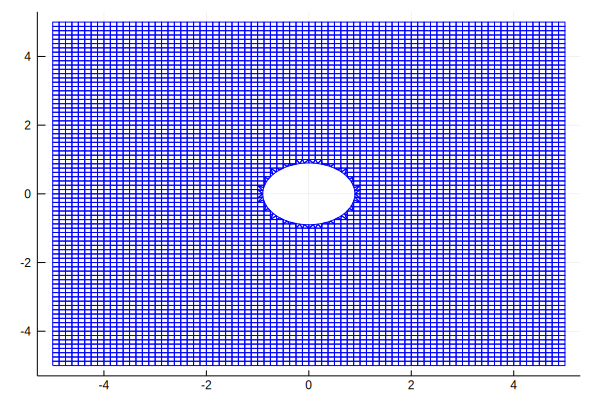

In [31]:
#Original Geometry
plotmesh()

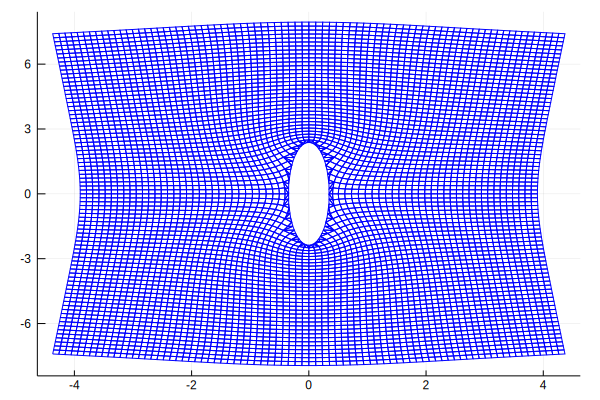

In [32]:
#Deformed Geometry
plotsolution()

In [38]:
#Evaluate Stresses at an OFE Node (Work in Progress)
#Returns [σ_xx, σ_yy, σ_xy] once for each triangular element the node is part of 
EvalNode = 6464
TriOFE2D(3,Stiffness)

[99775.1; 3.44419e6; -1.32125e5]
[2.39733e5; 3.03274e6; -7.20261e-9]
[99775.1; 3.44419e6; 1.32125e5]
[2.39733e5; 3.03274e6; -6.30153e-9]


In [34]:
#Global Stiffness Matrix
Matrix(Stiffness)

13564×13564 Array{Float64,2}:
  99876.6    37313.4    -62282.6          …    0.0            0.0        
  37313.4    99876.6       280.552             0.0            0.0        
 -62282.6      280.552       1.99753e5         0.0            0.0        
   -280.552  12344.3        -5.09317e-11       0.0            0.0        
      0.0        0.0    -62282.6               0.0            0.0        
      0.0        0.0      -280.552        …    0.0            0.0        
      0.0        0.0         0.0               0.0            0.0        
      0.0        0.0         0.0               0.0            0.0        
      0.0        0.0         0.0               0.0            0.0        
      0.0        0.0         0.0               0.0            0.0        
      0.0        0.0         0.0          …    0.0            0.0        
      0.0        0.0         0.0               0.0            0.0        
      0.0        0.0         0.0               0.0            0.0        
      ⋮ 

In [35]:
#Force vectors for the various DOFs
#=
for i = 1:NEQ
    if (i < 100)
        print("DOF ", i , ":\t\t", newR[i], "N\n");
    else
        print("DOF ", i , ":\t", newR[i], "N\n");
    end
end
=#

In [36]:
#DOF indexing for each node
#=
for i = 1:NUMNP
    if (i < 10)
        print("Node ", i, ":\t\t");
    else
        print("Node ", i, ":\t");
    end
    for j = 1:2*NumMonomials
        print(Int(OFEID[i,j]), "\t")
    end
    print("\n");
end
=#

In [37]:
#Nodal Displacements
[["Node";range(1,stop=length(u[:,1]),length(u[:,1]))] ["u_x" "u_y";u]]

6465×3 Array{Any,2}:
     "Node"   "u_x"      "u_y"     
    1        0.630173  -2.40708    
    2        0.609545  -2.42171    
    3        0.588904  -2.43632    
    4        0.568242  -2.45095    
    5        0.547555  -2.46561    
    6        0.526851  -2.48032    
    7        0.506138  -2.49511    
    8        0.485428  -2.51       
    9        0.464737  -2.525      
   10        0.444085  -2.54013    
   11        0.423493  -2.55541    
   12        0.402988  -2.57084    
    ⋮                              
 6453        0.259102  -1.29976    
 6454        0.301123  -1.22379    
 6455        0.347441  -1.13841    
 6456        0.387971  -1.03881    
 6457        0.423107  -0.930743   
 6458        0.456934  -0.812714   
 6459        0.484423  -0.695573   
 6460        0.509977  -0.55985    
 6461        0.528776  -0.423387   
 6462        0.539506  -0.29002    
 6463        0.550769  -0.145606   
 6464        0.555689  -7.72887e-13